请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 

# 框架自带数据集

# 实验一、美食评分

In [1]:
#解压图像文件,用Linux命令
!unzip data_foodscore.zip -d data/datafood


Archive:  data_foodscore.zip
  inflating: data/datafood/FoodScore.csv  
   creating: data/datafood/data_foodscore/
  inflating: data/datafood/data_foodscore/pic1.jpg  
  inflating: data/datafood/data_foodscore/pic10.jpg  
  inflating: data/datafood/data_foodscore/pic100.jpg  
  inflating: data/datafood/data_foodscore/pic101.jpg  
  inflating: data/datafood/data_foodscore/pic102.jpg  
  inflating: data/datafood/data_foodscore/pic103.jpg  
  inflating: data/datafood/data_foodscore/pic104.jpg  
  inflating: data/datafood/data_foodscore/pic105.jpg  
  inflating: data/datafood/data_foodscore/pic106.jpg  
  inflating: data/datafood/data_foodscore/pic107.jpg  
  inflating: data/datafood/data_foodscore/pic108.jpg  
  inflating: data/datafood/data_foodscore/pic109.jpg  
  inflating: data/datafood/data_foodscore/pic11.jpg  
  inflating: data/datafood/data_foodscore/pic110.jpg  
  inflating: data/datafood/data_foodscore/pic111.jpg  
  inflating: data/datafood/data_foodscore/pic112.jpg  
  inflati

# 第一步、定义数据集

In [11]:
import paddle
from paddle.io import Dataset
import pandas as pd
import numpy as np
from PIL import Image 
#自定义数据集
class FoodDataset(Dataset):
    #初始化数据集
    def __init__(self,train=True,transforms=None):
        #调用基类构造函数
        super().__init__()
        #传入数据预处理
        self.transforms=transforms
        #导入csv
        df_foodscore=pd.read_csv("data/datafood/FoodScore.csv")  #dataframe类型数据
        offset=int(len(df_foodscore)*0.7)
        if train==True:
            df_foodscore=df_foodscore[:offset]
        else:
            df_foodscore=df_foodscore[offset:]
        self.score=np.array(df_foodscore["score"]).astype("float32")  #把dataframe转化numpy.array   标签数据集
        picname=df_foodscore["ID"]

        self.data=[]  #图像数据集
        for name in picname:
            filepath="data/datafood/data_foodscore/{}.jpg".format(name)
            photo=Image.open(filepath)
            matrix=np.array(photo).astype("float32")
            self.data.append(matrix)

    #获取单个数据
    def __getitem__(self,index):
        data=self.data[index]
        if self.transforms!=None:
            data=self.transforms(data) #把数据预处理应用到每个图像
        label=self.score[index]
        return data,label

    #回去数据集长度
    def __len__(self):
        return len(self.score)

# 第二步、数据预处理

In [10]:
#数据预处理，图像统一尺寸、归一化、张量
import paddle.vision.transforms as T
#数据预处理组合
trans=T.Compose([T.Resize([128,128]),T.Normalize(mean=[0,0,0],std=[255,255,255],data_format="HWC"),T.ToTensor()])
#创建数据集对象
train_dataset=FoodDataset(train=True,transforms=trans)
eval_dataset=FoodDataset(train=False,transforms=trans)
#数据加载，分批
train_loader=paddle.io.DataLoader(dataset=train_dataset,batch_size=20,shuffle=True)
eval_loader=paddle.io.DataLoader(dataset=eval_dataset,batch_size=20,shuffle=True)


# 第三步、网络组建

In [4]:
#组建网络
class FoodNet(paddle.nn.Layer):
    #初始化每层结构对象
    def __init__(self):
        super().__init__()
        self.flatten=paddle.nn.Flatten()
        self.linear=paddle.nn.Linear(128*128*3,1)

    #前向传播
    def forward(self,x):
        y=self.flatten(x)
        y=self.linear(y)
        return y

#实例化网络
foodNet=FoodNet()
paddle.summary(foodNet,(10,3,128,128))


---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Flatten-1    [[10, 3, 128, 128]]      [10, 49152]             0       
   Linear-1        [[10, 49152]]           [10, 1]            49,153     
Total params: 49,153
Trainable params: 49,153
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 1.88
Forward/backward pass size (MB): 3.75
Params size (MB): 0.19
Estimated Total Size (MB): 5.81
---------------------------------------------------------------------------



{'total_params': 49153, 'trainable_params': 49153}

# 第四步、配置网络、训练网络、保存网络

In [8]:
#使用高层API
#封装模型对象
model=paddle.Model(foodNet)

#配置训练
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters(),learning_rate=0.001),
               loss=paddle.nn.MSELoss())
#训练模型
model.fit(train_data=train_loader,batch_size=20,verbose=1,epochs=10)
#保存模型
model.save("mymodel/FoodNet")

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step 7/7 [==============================] - loss: 30.4874 - 18ms/step
Epoch 2/10
step 7/7 [==============================] - loss: 31.4835 - 18ms/step
Epoch 3/10
step 7/7 [==============================] - loss: 55.5307 - 17ms/step
Epoch 4/10
step 7/7 [==============================] - loss: 33.0255 - 18ms/step
Epoch 5/10
step 7/7 [==============================] - loss: 3.2529 - 17ms/step
Epoch 6/10
step 7/7 [==============================] - loss: 4.1197 - 17ms/step
Epoch 7/10
step 7/7 [==============================] - loss: 5.8679 - 17ms/step
Epoch 8/10
step 7/7 [==============================] - loss: 1.8154 - 17ms/step
Epoch 9/10
step 7/7 [==============================] - loss: 2.6947 - 17ms/step
Epoch 10/10
step 7/7 [==============================] - loss: 1.2406 - 18ms/step


# 第五步、加载模型，借助高层API,用模型对象对新的数据进行预测

分数：[[2.5780776]]


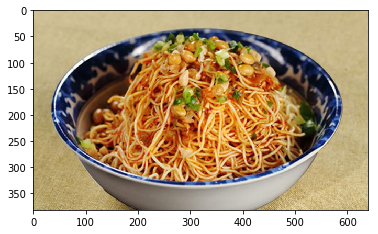

In [9]:
import matplotlib.pyplot as plt
#创建模型对象
foodNet=FoodNet()
model=paddle.Model(foodNet)   #调用高层API对模型对象封装
#加载模型参数
model.load("mymodel/FoodNet")
#加载图片
photo=Image.open("myfood/3.jpg")
#把图像显示出来
plt.imshow(photo)
#把图片数字化
im=np.array(photo).astype("float32")
#把新的图像数据进行预处理
im=trans(im)
im=im.reshape([1,3,128,128])

#进行预测
result=model.predict_batch(im)
print("分数：{}".format(result[0]))